This data loader is implemented using tensorflow-gpu=2.x framework

### Libraries and data loading

In [4]:
# import libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import datetime
import itertools
import h5py
import matplotlib.dates as mdates
import numpy.ma as ma
import CRPS.CRPS as pscore

%matplotlib inline

In [2]:
# check tensorflow version
print("tensorflow version:", tf.__version__)
# check available gpu
gpus =  tf.config.list_physical_devices('GPU')
print("available gpus:", gpus)
# limit the gpu usage, prevent it from allocating all gpu memory for a simple model
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# check number of cpus available
print("available cpus:", os.cpu_count())

tensorflow version: 2.4.1
available gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
available cpus: 128


In [3]:
# define the data location and load data
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
data_folder = os.path.join(pardir,"data")
data_path = os.path.join(data_folder, "dataset_all",'video_prediction_dataset.hdf5')

# !change model name for different models!
model_name = 'CNN_forecast_SUNSET_2017_2019_data'
output_folder = os.path.join(cwd,"model_output", model_name)
if os.path.isdir(output_folder)==False:
    os.makedirs(output_folder)

print("data_folder:", data_folder)
print("data_path:", data_path)
print("output_folder:", output_folder)

data_folder: /scratch/groups/abrandt/solar_forecasting/GAN_project_new/data
data_path: /scratch/groups/abrandt/solar_forecasting/GAN_project_new/data/dataset_all/video_prediction_dataset.hdf5
output_folder: /scratch/groups/abrandt/solar_forecasting/GAN_project_new/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data


In [6]:
# generate handler for the hdf5 data
forecast_dataset = h5py.File(data_path, 'r')

# show structure of the hdf5 data
def get_all(name):
    if name!=None:
        print(forecast_dataset[name])
    
forecast_dataset.visit(get_all)

<HDF5 group "/test" (4 members)>
<HDF5 dataset "images_log": shape (4467, 16, 64, 64, 3), type "|u1">
<HDF5 dataset "images_pred": shape (4467, 15, 64, 64, 3), type "|u1">
<HDF5 dataset "pv_log": shape (4467, 16), type "<f4">
<HDF5 dataset "pv_pred": shape (4467, 15), type "<f4">
<HDF5 group "/trainval" (4 members)>
<HDF5 dataset "images_log": shape (53336, 16, 64, 64, 3), type "|u1">
<HDF5 dataset "images_pred": shape (53336, 15, 64, 64, 3), type "|u1">
<HDF5 dataset "pv_log": shape (53336, 16), type "<f4">
<HDF5 dataset "pv_pred": shape (53336, 15), type "<f4">


In [7]:
print('-'*50)
# get the input dimension for constructing the model
# the input images will be reshaped from (None, 8, 64, 64, 3) to (None, 64, 64, 24)
img_side_len = forecast_dataset['trainval']['images_log'].shape[2]
num_log_term = forecast_dataset['trainval']['images_log'].shape[1]
num_pred_term = forecast_dataset['trainval']['pv_pred'].shape[1]
num_color_channel = forecast_dataset['trainval']['images_log'].shape[4]
image_input_dim = [img_side_len,img_side_len,num_log_term*num_color_channel]

print("image side length:", img_side_len)
print("number of log terms:", num_log_term)
print("number of pred terms:", num_pred_term)
print("number of color channels:", num_color_channel)
print("input image dimension:", image_input_dim)

# load time stamps into the memory
times_trainval = np.load(os.path.join(data_folder,"dataset_all","times_curr_trainval.npy"),allow_pickle=True)
print("times_trainval.shape:", times_trainval.shape)

# read through the dataset once in order to cache it but not store it into the memory
## read the data by batch
batch_size = 10000
num_samples = len(times_trainval)
indices = np.arange(num_samples)
print('-'*50)
print('data reading start...')
for i in range(int(num_samples / batch_size) + 1):
    start_time = time.time()
    start_idx = (i * batch_size) % num_samples
    idxs = indices[start_idx:start_idx + batch_size]
    _ = forecast_dataset['trainval']['images_log'][idxs]
    _ = forecast_dataset['trainval']['pv_log'][idxs]
    _ = forecast_dataset['trainval']['pv_pred'][idxs]
    end_time = time.time()
    print("batch {0} samples: {1} to {2}, {3:.2f}% finished, processing time {4:.2f}s"
          .format(i+1, idxs[0],idxs[-1],(idxs[-1]/num_samples)*100,(end_time-start_time)))

# temporially close the dataset, will use "with" statement to open it when we use it
forecast_dataset.close()

--------------------------------------------------
image side length: 64
number of log terms: 16
number of pred terms: 15
number of color channels: 3
input image dimension: [64, 64, 48]
times_trainval.shape: (53336,)
--------------------------------------------------
data reading start...
batch 1 samples: 0 to 9999, 18.75% finished, processing time 2.58s
batch 2 samples: 10000 to 19999, 37.50% finished, processing time 2.28s
batch 3 samples: 20000 to 29999, 56.25% finished, processing time 1.01s
batch 4 samples: 30000 to 39999, 74.99% finished, processing time 1.01s
batch 5 samples: 40000 to 49999, 93.74% finished, processing time 1.10s
batch 6 samples: 50000 to 53335, 100.00% finished, processing time 0.34s


### Input data pipeline helper functions

In [8]:
# day block shuffling of the time stamps, and return shuffled indices
def day_block_shuffle(times_trainval):
    
    # Only keep the date of each time point
    dates_trainval = np.zeros_like(times_trainval, dtype=datetime.date)
    for i in range(len(times_trainval)):
        dates_trainval[i] = times_trainval[i].date()

    # Chop the indices into blocks, so that each block contains the indices of the same day
    unique_dates = np.unique(dates_trainval)
    blocks = []
    for i in range(len(unique_dates)):
        blocks.append(np.where(dates_trainval == unique_dates[i])[0])

    # shuffle the blocks, and chain it back together
    np.random.seed(1)
    np.random.shuffle(blocks)
    shuffled_indices = np.asarray(list(itertools.chain.from_iterable(blocks)))

    return shuffled_indices

In [9]:
# a cross validation generator function for spliting the dayblock shuffled indices into training and validation
def cv_split(split_data, fold_index, num_fold):
    '''
    input:
    split_data: the dayblock shuffled indices to be splitted
    fold_index: the ith fold chosen as the validation, used for generating the seed for random shuffling
    num_fold: N-fold cross validation
    output:
    data_train: the train data indices
    data_val: the validation data indices
    '''
    # randomly divides into a training set and a validation set
    num_samples = len(split_data)
    indices = np.arange(num_samples)

    # finding training and validation indices
    val_mask = np.zeros(len(indices), dtype=bool)
    val_mask[int(fold_index / num_fold * num_samples):int((fold_index + 1) / num_fold * num_samples)] = True
    val_indices = indices[val_mask]
    train_indices = indices[np.logical_not(val_mask)]

    # shuffle indices
    np.random.seed(fold_index)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    
    data_train = split_data[train_indices]
    data_val = split_data[val_indices]

    return data_train,data_val

In [5]:
def process_image(image_data):
    '''
    image data processing: reshaping and normalization
    '''
    ## reshape the image tensor from [None,8,64,64,3] to [None,64,64,24]
    image_data = tf.transpose(image_data,perm=[0,2,3,1,4])
    image_data = tf.reshape(image_data, [image_data.shape[0],image_data.shape[1],image_data.shape[2],-1])

    ## normalize the image to [0,1]
    image_data = tf.image.convert_image_dtype(image_data, tf.float32)

    return image_data

In [11]:
# a mapping function from the indices to the corresponding features and labels 
def data_loader(hdf5_data_path,sample_idx,batch_size=256):
    '''
    input:
    hdf5_data_path: path to hdf5 data file
    sample_idx: 
        for training and validation:
            dayblock shuffled indices with cross-validation split into training and validation
            either training or validation indices will be input
        for testing: the indices are not shuffled
    is_trainval: a flag, True for trainig and validation
    output:
    dataset: dataset for training, validation
    '''

    def mapping_func_py(hdf5_data_path,sample_idx):
        '''
        mapping indices to corresponding images and pviance data in hdf5 (python expression)
        '''
        # convert EagerTensor to str or numpy array
        hdf5_data_path = hdf5_data_path.numpy().decode() 
        # sort the sample indices as hdf5 requires increasing order index for data retrieval
        sample_idx = sorted(sample_idx.numpy())

        with h5py.File(hdf5_data_path,'r') as f:

            # read in the data
            images_log = f['trainval']['images_log'][sample_idx]
            pv_log = f['trainval']['pv_log'][sample_idx]
            pv_pred = f['trainval']['pv_pred'][sample_idx][:,-1]

            # process image data
            images_log = process_image(images_log)
            
            # convert pv data to tf.tensor
            pv_log = tf.convert_to_tensor(pv_log, dtype=tf.float32)
            pv_pred = tf.convert_to_tensor(pv_pred, dtype=tf.float32)

            return images_log, pv_log, pv_pred

    def mapping_func_tf(hdf5_data_path,sample_idx):
        '''
        a wrapper mapping function to get the nested data structure 
        the output type of tf.py_function cannot be a nested sequence when using a tf.py_function with the tf.data API
        '''
        images_log, pv_log, pv_pred = tf.py_function(func=mapping_func_py,
                                                           inp=[hdf5_data_path, sample_idx], 
                                                           Tout=(tf.float32, tf.float32, tf.float32))
        return (images_log, pv_log), pv_pred
    
    
    # create the indices dataset
    idx_ds = tf.data.Dataset.from_tensor_slices(sample_idx)
    # shuffle and batch the indices
    idx_ds = idx_ds.shuffle(buffer_size = idx_ds.cardinality().numpy(),seed=0)
    idx_ds = idx_ds.batch(batch_size).repeat().prefetch(tf.data.experimental.AUTOTUNE)
    
    # indices dataset mapping to images and pviance data
    # returning dataset with the following nested structure: (images_log, pv_log), pv_pred
    dataset = idx_ds.map(lambda x: mapping_func_tf(hdf5_data_path,x),
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset

In [5]:
def compute_winkler_score(prob_prediction,observation):
    alpha = 0.1
    lb = np.percentile(prob_prediction,5,axis=0)
    ub = np.percentile(prob_prediction,95,axis=0)
    delta = ub-lb
    if observation<lb:
        sc = delta+2*(lb-observation)/alpha
    if observation>ub:
        sc = delta+2*(observation-ub)/alpha
    if (observation>=lb) and (observation<=ub):
        sc = delta
    return sc

### Model architecture

In [5]:
# define model characteristics
num_filters = 24
kernel_size = [3,3]
pool_size = [2,2]
strides = 2
dense_size = 1024
drop_rate = 0.4

# define training time parameters
num_epochs = 200 #(The maximum epoches set to 200 and there might be early stopping depends on validation loss)
num_fold = 10 # 10-fold cross-validation
batch_size = 256
learning_rate = 3e-06

In [13]:
# define the model architecture using tf.keras API
def sunset_model():
    ## input
    ### input image logs with shape (64,64,24)
    x_in = keras.Input(shape=image_input_dim)
    ### input pviance/pv output logs with shape (8)
    x2_in = keras.Input(shape=num_log_term)

    ## 1st convolution block
    x = keras.layers.Conv2D(num_filters,kernel_size,padding="same",activation='relu')(x_in)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size, strides)(x)

    ## 2nd convolution block
    x = keras.layers.Conv2D(num_filters*2,kernel_size,padding="same",activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size, strides)(x)

    ## 3rd convolution block
    #x = keras.layers.Conv2D(num_filters*4,kernel_size,padding="same",activation='relu')(x)
    #x = keras.layers.BatchNormalization()(x)
    #x = keras.layers.MaxPooling2D(pool_size, strides)(x)

    ## two fully connected nets
    x = keras.layers.Flatten()(x)
    x = keras.layers.Concatenate(axis=1)([x, x2_in])

    x = keras.layers.Dense(dense_size, activation='relu')(x)
    x = keras.layers.Dropout(drop_rate)(x)
    x = keras.layers.Dense(dense_size, activation='relu')(x)
    x = keras.layers.Dropout(drop_rate)(x)

    ## regression to prediction target
    y_out = keras.layers.Dense(units=1)(x)

    # construct the model
    model = keras.Model(inputs=[x_in, x2_in],outputs=y_out)

    return model

# show model architecture
sunset_model().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 48)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 24)   10392       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 24)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 24)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Model training and validation

Repetition 1 model training started ...
Epoch 1/200
188/188 [==============================] - 134s 692ms/step - loss: 88.7488 - val_loss: 57.8385

Epoch 00001: val_loss improved from inf to 57.83851, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_1/best_model_repitition_1.h5
Epoch 2/200
188/188 [==============================] - 129s 688ms/step - loss: 17.3728 - val_loss: 13.9714

Epoch 00002: val_loss improved from 57.83851 to 13.97135, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_1/best_model_repitition_1.h5
Epoch 3/200
188/188 [==============================] - 129s 689ms/step - loss: 14.7235 - val_loss: 11.0476

Epoch 00003: val_loss improved from 13.97135 to 11.04759, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_1/best_model_repitition_1.h5
Epoch

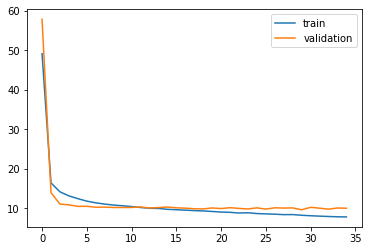

Repetition 2 model training started ...
Epoch 1/200
188/188 [==============================] - 132s 697ms/step - loss: 125.0031 - val_loss: 85.4967

Epoch 00001: val_loss improved from inf to 85.49667, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_2/best_model_repitition_2.h5
Epoch 2/200
188/188 [==============================] - 130s 692ms/step - loss: 20.4743 - val_loss: 24.4394

Epoch 00002: val_loss improved from 85.49667 to 24.43942, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_2/best_model_repitition_2.h5
Epoch 3/200
188/188 [==============================] - 130s 692ms/step - loss: 16.1085 - val_loss: 13.0969

Epoch 00003: val_loss improved from 24.43942 to 13.09686, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_2/best_model_repitition_2.h5
Epoc

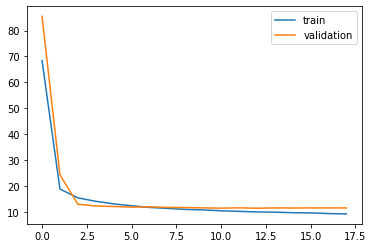

Repetition 3 model training started ...
Epoch 1/200
188/188 [==============================] - 132s 692ms/step - loss: 69.8942 - val_loss: 66.2090

Epoch 00001: val_loss improved from inf to 66.20900, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_3/best_model_repitition_3.h5
Epoch 2/200
188/188 [==============================] - 130s 692ms/step - loss: 16.7515 - val_loss: 22.5354

Epoch 00002: val_loss improved from 66.20900 to 22.53543, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_3/best_model_repitition_3.h5
Epoch 3/200
188/188 [==============================] - 131s 695ms/step - loss: 14.3363 - val_loss: 13.2145

Epoch 00003: val_loss improved from 22.53543 to 13.21448, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_3/best_model_repitition_3.h5
Epoch

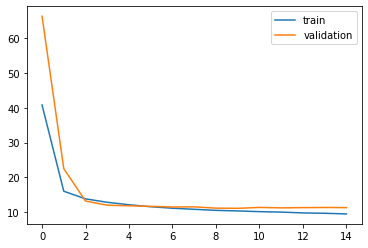

Repetition 4 model training started ...
Epoch 1/200
188/188 [==============================] - 132s 694ms/step - loss: 84.0773 - val_loss: 73.8679

Epoch 00001: val_loss improved from inf to 73.86790, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_4/best_model_repitition_4.h5
Epoch 2/200
188/188 [==============================] - 130s 691ms/step - loss: 18.1784 - val_loss: 21.5640

Epoch 00002: val_loss improved from 73.86790 to 21.56401, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_4/best_model_repitition_4.h5
Epoch 3/200
188/188 [==============================] - 130s 692ms/step - loss: 15.2743 - val_loss: 10.5490

Epoch 00003: val_loss improved from 21.56401 to 10.54902, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_4/best_model_repitition_4.h5
Epoch

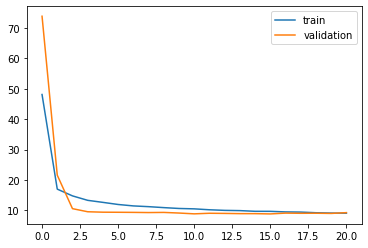

Repetition 5 model training started ...
Epoch 1/200
188/188 [==============================] - 133s 698ms/step - loss: 78.9704 - val_loss: 60.9864

Epoch 00001: val_loss improved from inf to 60.98635, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_5/best_model_repitition_5.h5
Epoch 2/200
188/188 [==============================] - 131s 697ms/step - loss: 17.9319 - val_loss: 16.7835

Epoch 00002: val_loss improved from 60.98635 to 16.78355, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_5/best_model_repitition_5.h5
Epoch 3/200
188/188 [==============================] - 131s 698ms/step - loss: 15.0498 - val_loss: 8.9345

Epoch 00003: val_loss improved from 16.78355 to 8.93447, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_5/best_model_repitition_5.h5
Epoch 4

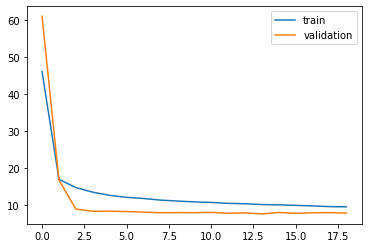

Repetition 6 model training started ...
Epoch 1/200
188/188 [==============================] - 133s 700ms/step - loss: 89.0404 - val_loss: 87.2149

Epoch 00001: val_loss improved from inf to 87.21487, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_6/best_model_repitition_6.h5
Epoch 2/200
188/188 [==============================] - 131s 700ms/step - loss: 19.3805 - val_loss: 27.6046

Epoch 00002: val_loss improved from 87.21487 to 27.60459, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_6/best_model_repitition_6.h5
Epoch 3/200
188/188 [==============================] - 132s 701ms/step - loss: 15.7181 - val_loss: 11.7399

Epoch 00003: val_loss improved from 27.60459 to 11.73993, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_6/best_model_repitition_6.h5
Epoch

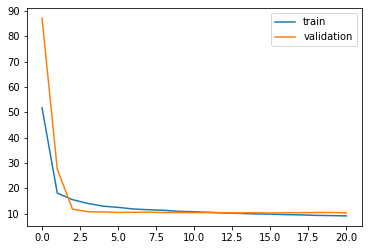

Repetition 7 model training started ...
Epoch 1/200
188/188 [==============================] - 133s 701ms/step - loss: 84.4678 - val_loss: 63.5989

Epoch 00001: val_loss improved from inf to 63.59890, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_7/best_model_repitition_7.h5
Epoch 2/200
188/188 [==============================] - 131s 699ms/step - loss: 17.3592 - val_loss: 24.3047

Epoch 00002: val_loss improved from 63.59890 to 24.30473, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_7/best_model_repitition_7.h5
Epoch 3/200
188/188 [==============================] - 131s 699ms/step - loss: 14.7890 - val_loss: 12.1729

Epoch 00003: val_loss improved from 24.30473 to 12.17293, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_7/best_model_repitition_7.h5
Epoch

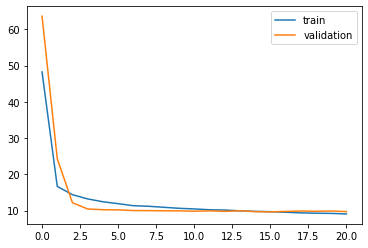

Repetition 8 model training started ...
Epoch 1/200
188/188 [==============================] - 134s 706ms/step - loss: 84.4495 - val_loss: 72.7725

Epoch 00001: val_loss improved from inf to 72.77245, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_8/best_model_repitition_8.h5
Epoch 2/200
188/188 [==============================] - 132s 702ms/step - loss: 18.1806 - val_loss: 16.4022

Epoch 00002: val_loss improved from 72.77245 to 16.40222, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_8/best_model_repitition_8.h5
Epoch 3/200
188/188 [==============================] - 132s 701ms/step - loss: 15.3156 - val_loss: 6.7882

Epoch 00003: val_loss improved from 16.40222 to 6.78821, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_8/best_model_repitition_8.h5
Epoch 4

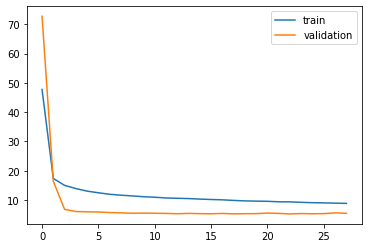

Repetition 9 model training started ...
Epoch 1/200
188/188 [==============================] - 134s 707ms/step - loss: 86.2246 - val_loss: 58.8648

Epoch 00001: val_loss improved from inf to 58.86483, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_9/best_model_repitition_9.h5
Epoch 2/200
188/188 [==============================] - 132s 701ms/step - loss: 17.9445 - val_loss: 12.9625

Epoch 00002: val_loss improved from 58.86483 to 12.96251, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_9/best_model_repitition_9.h5
Epoch 3/200
188/188 [==============================] - 132s 701ms/step - loss: 14.8693 - val_loss: 8.2753

Epoch 00003: val_loss improved from 12.96251 to 8.27528, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_9/best_model_repitition_9.h5
Epoch 4

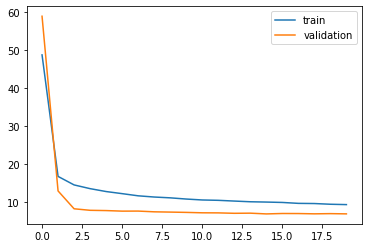

Repetition 10 model training started ...
Epoch 1/200
188/188 [==============================] - 133s 702ms/step - loss: 104.7950 - val_loss: 97.2047

Epoch 00001: val_loss improved from inf to 97.20473, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_10/best_model_repitition_10.h5
Epoch 2/200
188/188 [==============================] - 132s 704ms/step - loss: 20.5207 - val_loss: 34.5707

Epoch 00002: val_loss improved from 97.20473 to 34.57074, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_10/best_model_repitition_10.h5
Epoch 3/200
188/188 [==============================] - 132s 700ms/step - loss: 16.5221 - val_loss: 11.6800

Epoch 00003: val_loss improved from 34.57074 to 11.67999, saving model to /scratch/groups/abrandt/GAN_project/models/SUNSET/model_output/CNN_forecast_SUNSET_2017_2019_data/repetition_10/best_model_repitition_10.

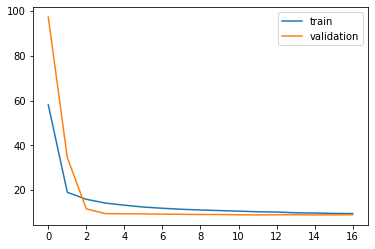

In [14]:
# generate dayblock shuffled indices
indices_dayblock_shuffled = day_block_shuffle(times_trainval)

# initialize loss history list
train_loss_hist = []
val_loss_hist = []
    
for i in range(num_fold):
    
    # construct and compile model for each repetition to reinitialize the model weights
    keras.backend.clear_session()
    model = sunset_model()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),loss='mse')
    
    # implementing 10-fold cross-validation
    print('Repetition {0} model training started ...'.format(i+1))
    
    # creating folder for saving model checkpoint
    save_directory = os.path.join(output_folder,'repetition_'+str(i+1))
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        
    # training and validation data preparation
    ## generate indices dataset for training and validation
    indices_train, indices_val = cv_split(indices_dayblock_shuffled,i,num_fold)
    ## load data from dataloader
    ds_train_batched = data_loader(data_path,indices_train)
    ds_val_batched = data_loader(data_path,indices_val,batch_size=500)

    # define callbacks for training
    ## early stopping rule: if the validation loss stop decreasing for 5 consecutive epoches
    earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    ## model check point: save model checkpoint for later use
    checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(save_directory,'best_model_repitition_'+str(i+1)+'.h5'), 
                                monitor='val_loss', mode='min', save_best_only=True, verbose=1)

    # training the model and record training and validation loss
    history = model.fit(ds_train_batched, epochs=num_epochs, steps_per_epoch=len(indices_train)//batch_size+1,
                               verbose=1, callbacks=[earlystop,checkpoint], validation_data=ds_val_batched,
                              validation_steps=len(indices_val)//batch_size+1)
    train_loss_hist.append(history.history['loss'])
    val_loss_hist.append(history.history['val_loss'])

    # plot training and validation history
    plt.plot(train_loss_hist[i],label='train')
    plt.plot(val_loss_hist[i],label='validation')
    plt.legend()
    plt.show()

# saving model training and validation loss history
np.save(os.path.join(output_folder,'train_loss_hist.npy'),train_loss_hist)
np.save(os.path.join(output_folder,'val_loss_hist.npy'),val_loss_hist)

In [22]:
# summary of training and validation results
best_train_loss_MSE = np.zeros(num_fold)
best_val_loss_MSE = np.zeros(num_fold)

for i in range(num_fold):
    best_val_loss_MSE[i] = np.min(val_loss_hist[i])
    idx = np.argmin(val_loss_hist[i])
    best_train_loss_MSE[i] = train_loss_hist[i][idx]
    print('Model {0}  -- train loss: {1:.2f}, validation loss: {2:.2f} (RMSE)'.format(i+1, np.sqrt(best_train_loss_MSE[i]), np.sqrt(best_val_loss_MSE[i])))
print('The mean train loss (RMSE) for all models is {0:.2f}'.format(np.mean(np.sqrt(best_train_loss_MSE))))
print('The mean validation loss (RMSE) for all models is {0:.2f}'.format(np.mean(np.sqrt(best_val_loss_MSE))))

Model 1  -- train loss: 2.87, validation loss: 3.10 (RMSE)
Model 2  -- train loss: 3.18, validation loss: 3.40 (RMSE)
Model 3  -- train loss: 3.22, validation loss: 3.34 (RMSE)
Model 4  -- train loss: 3.11, validation loss: 2.97 (RMSE)
Model 5  -- train loss: 3.19, validation loss: 2.76 (RMSE)
Model 6  -- train loss: 3.13, validation loss: 3.19 (RMSE)
Model 7  -- train loss: 3.12, validation loss: 3.11 (RMSE)
Model 8  -- train loss: 3.06, validation loss: 2.29 (RMSE)
Model 9  -- train loss: 3.17, validation loss: 2.63 (RMSE)
Model 10  -- train loss: 3.23, validation loss: 3.00 (RMSE)
The mean train loss (RMSE) for all models is 3.13
The mean validation loss (RMSE) for all models is 2.98


### Model testing

In [6]:
# load testing data
times_test = np.load(os.path.join(data_folder,"dataset_all","times_curr_test.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

with h5py.File(data_path,'r') as f:

    # read in the data
    images_log_test = f['test']['images_log'][...]
    pv_log_test = f['test']['pv_log'][...]
    pv_pred_test = f['test']['pv_pred'][...][:,-1]

    # process image data
    images_log_test = process_image(images_log_test).numpy()

print("images_log_test.shape:",images_log_test.shape)
print("pv_log_test.shape:",pv_log_test.shape)
print("pv_pred_test.shape:",pv_pred_test.shape)

times_test.shape: (4467,)


InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: all CUDA-capable devices are busy or unavailable

In [17]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)
    
    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=[images_log_test,pv_log_test], y=pv_pred_test, batch_size=200, verbose=1)
    
    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict([images_log_test,pv_log_test], batch_size=200, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction 
print('-'*50)
print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_ensemble = np.sqrt(np.mean((prediction_ensemble-pv_pred_test)**2))
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_ensemble))

loading repetition 1 model ...
evaluating performance for the model
23/23 [==============================] - 4s 142ms/step - loss: 14.8479
generating predictions for the model
23/23 [==============================] - 3s 131ms/step
loading repetition 2 model ...
evaluating performance for the model
23/23 [==============================] - 3s 134ms/step - loss: 15.3457
generating predictions for the model
23/23 [==============================] - 3s 131ms/step
loading repetition 3 model ...
evaluating performance for the model
23/23 [==============================] - 3s 133ms/step - loss: 15.6123
generating predictions for the model
23/23 [==============================] - 3s 131ms/step
loading repetition 4 model ...
evaluating performance for the model
23/23 [==============================] - 3s 133ms/step - loss: 15.4973
generating predictions for the model
23/23 [==============================] - 3s 131ms/step
loading repetition 5 model ...
evaluating performance for the model
23/23 [=

In [6]:
# load testing data
times_test = np.load(os.path.join(data_folder,"dataset_all","times_curr_test.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

with h5py.File(data_path,'r') as f:

    # read in the data
    pv_pred_test = f['test']['pv_pred'][...][:,-1]

print("pv_pred_test.shape:",pv_pred_test.shape)

times_test.shape: (4467,)
pv_pred_test.shape: (4467,)


In [8]:
prediction = np.load(os.path.join(output_folder,'test_predictions.npy'))

# using the ensemble mean of the 10 models as the final prediction 
prediction_ensemble = np.mean(prediction,axis=0)

loss_ensemble = np.sqrt(np.mean((prediction_ensemble-pv_pred_test)**2))
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_ensemble))

MAE = np.mean(np.abs((prediction_ensemble-pv_pred_test)))
MAE

the test set RMSE is 3.870 for the ensemble model


2.7579826371194907

In [9]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction[:,i],pv_pred_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

The mean crps: 2.473


In [10]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction[:,i],pv_pred_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

The mean Winkler score: 41.726


In [13]:
# formulate sunny and cloudy test days
sunny_dates = [(2017,5,20),(2017,10,7),(2017,11,1),
        (2018,5,28),(2018,6,29),(2018,10,13),
        (2019,6,23),(2019,7,31),(2019,8,13),(2019,10,21)]
cloudy_dates = [(2017,9,6),(2017,11,4),(2017,12,29),
        (2018,5,31),(2018,7,12),(2018,10,3),
        (2019,1,26),(2019,5,27),(2019,9,7),(2019,10,19)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [11]:
percent25_prediction = np.percentile(prediction,25,axis=0)
percent75_prediction = np.percentile(prediction,75,axis=0)
percent5_prediction = np.percentile(prediction,5,axis=0)
percent95_prediction = np.percentile(prediction,95,axis=0)

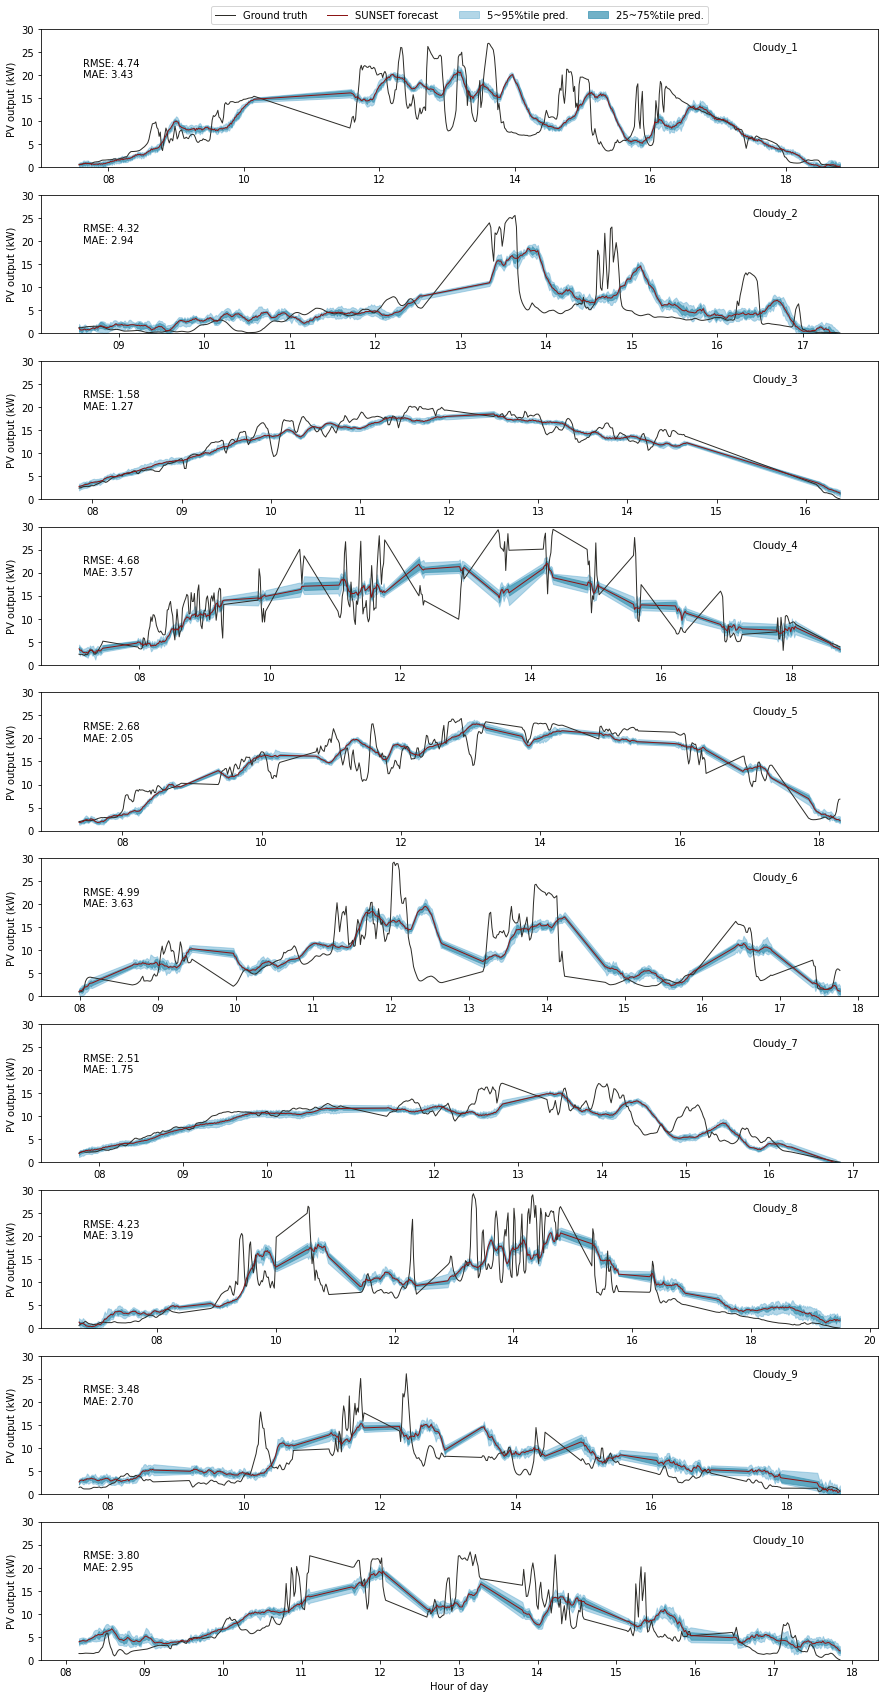

In [14]:
# visualization of forecast prediction_ensembles
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]] 
    
    rmse = np.sqrt(np.mean(np.square((pv_pred_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_pred_test[date_mask]-prediction_ensemble[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_pred_test[date_mask]-per_prediction_ensemble[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100
    
    ax.plot(hours_xaxis, pv_pred_test[date_mask], linewidth = 1, color=black, label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    #ax.fill_between(hours_xaxis, 0, pv_pred_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1, label = 'SUNSET forecast',color=red,markerfacecolor="None")
    #ax.plot(hours_xaxis, per_prediction_ensemble[date_mask],linewidth = 1,label = 'Persistence forecast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.2], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(15,30)
#plt.savefig(os.path.join(pardir,'results','sunset_forecast_baseline_2017_2019_full_data_trained_2019_test_days.pdf'), bbox_inches='tight',dpi=300)
plt.show()